# PANDA Approach #2 - End-to-end: Image Extraction

Since we have shown that the masks are not reliable enough to produce competitive results via the pseudo-segmentation method, we will now build a model that predicts an ISUP score directly from the input image. We still have the issues of massive images at full resolution and significant image portions of whitespace so we will still use a tiling approach; however, now we will recombine the tiles into one final image. In order to keep the resulting images at a reasonable size we tile at the intermediate resolution level (one-fourth of full resolution) and then down sample by one half

## Workspace Initialization and Data Setup

In [1]:
# General purpose packages
import os
import pandas as pd
import numpy as np
import zipfile
import pickle
from tqdm.notebook import tqdm
import time
import boto3
import math
import json
from shutil import copyfile
copyfile(src = "../input/edahelperfuncs/eda_helper_funcs.py", dst = "../working/eda_helper_funcs.py")
copyfile(src = "../input/tiling-ex/dual_grid_demo.JPG", dst = "../working/dual_grid_demo.JPG")
from eda_helper_funcs import *

# Image processing packages
import openslide
import cv2

Rather than move around the cummbersome ~400gb of data for this competition before proceeding with tiling, I will do the
image processing here and export the final condensed image to AWS where I prefer to do my computing. Due to the hard drive
limitation of Kaggle (20gb max write space), I will package  the images in increments of approximately that size for export,
wipe, and then repeat.

In [2]:
with open('../input/aws-creds/AWS_creds.json') as f:
    credentials = json.load(f)

s3client = boto3.client('s3',
    aws_access_key_id=credentials['aws_access_key_id'],
    aws_secret_access_key=credentials['aws_secret_access_key'])
bucket = 'kitt-panda-data'

In [3]:
# Here I hold out 800 images as a test set (in addition to the competition private test set) so that I can have 
# a full train/valid/test breakdown to check for performance and find trends/issues
train_df = pd.read_csv('../input/prostate-cancer-grade-assessment/train.csv').set_index('image_id')
test_df = train_df.sample(800, random_state=3)
test_df.to_csv('test_set.csv')
train_df = train_df.loc[ ~(train_df.index.isin(test_df.index))]
print('Training dataframe shape: ', train_df.shape)
print('Holdout dataframe shape: ', test_df.shape)
train_df.head(10)

Training dataframe shape:  (9816, 3)
Holdout dataframe shape:  (800, 3)


data_provider  isup_grade gleason_score
image_id                                                                
000920ad0b612851f8e01bcc880d9b3d    karolinska           0           0+0
0018ae58b01bdadc8e347995b69f99aa       radboud           4           4+4
001c62abd11fa4b57bf7a6c603a11bb9    karolinska           4           4+4
001d865e65ef5d2579c190a0e0350d8f    karolinska           0           0+0
002a4db09dad406c85505a00fb6f6144    karolinska           0           0+0
003046e27c8ead3e3db155780dc5498e    karolinska           1           3+3
0032bfa835ce0f43a92ae0bbab6871cb    karolinska           1           3+3
003a91841da04a5a31f808fb5c21538a    karolinska           1           3+3
003d4dd6bd61221ebc0bfb9350db333f    karolinska           1           3+3
00412139e6b04d1e1cee8421f38f6e90    karolinska           0           0+0

In [4]:
BASE_PATH = '../input/prostate-cancer-grade-assessment'
data_dir = f'{BASE_PATH}/train_images'
mask_dir = f'{BASE_PATH}/train_label_masks'

## Image Processing and Export to AWS

As with prior tiling strategies we will seek to prevent information degredation due to the placement of the original tiling grid. Here instead of using the 2-grid method demonstrated in the pseudo-segmentation notebook, an improved method that uses a variable number of grids (default = 4) is implemented, with each grid shifted sz/(number of "views") pixels horizontally and vertically from the original grid.

![dual_grid_display](dual_grid_demo.JPG "Using an additional tiling grid for better data quality")

In [5]:
def singleimage_extraction(image_id,views=4,sz=256,lvl=1,downsample=True,downsample_factor=2,
                           df=train_df,zip_file = ''):
    """Saves "views" number of final images for training into the provided zipfile and returns the 
    metadata for the images in a list
    
    Inputs:
        image_id: string, sample id from the training dataframe
        views: int, number of different grid placements to use to generate final images
        lvl: int (0-2), resolution level at which the image processing is done
        downsample: boolean, whether the image will be downsampled from the lvl resolution
        downsample_factor: int, number by which the current resolution should be divided, only applies if downsample=True
        df: dataframe, the dataframe that contains the scores for each sample image
        zip_file: open ZipFile into which the final images are saved
        
    Output:
        List containing a dictionary that contains all of the metadata for the saved images
    """
    img = open_slide_level(os.path.join(data_dir,f'{image_id}.tiff'), lvl)
    image_gleason_score = train_df.loc[image_id]['gleason_score'],
    image_isup_grade=train_df.loc[image_id]['isup_grade'],
    image_data_provider=train_df.loc[image_id]['data_provider']
    
    num_tiles = 36
    
    result = []
    
    # Ensure that image is padded to properly fit a grid of full tiles
    shape = img.shape
    pad0,pad1 = (sz - shape[0]%sz)%sz, (sz - shape[1]%sz)%sz
    base_img = np.pad(img,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2],[0,0]],
                constant_values=255)
    base_shape = base_img.shape
    
    # Implement "views" number of grids and create final images
    for i in range(views):
        if i == 0:
            temp_img = base_img
        else:      
            temp_img = base_img[int(sz/views)*i:-int(sz/views)*(views-i),
                                int(sz/views)*i:-int(sz/views)*(views-i),:]
        shape = temp_img.shape
        temp_img = temp_img.reshape(shape[0]//sz,sz,shape[1]//sz,sz,3)
        temp_img = temp_img.transpose(0,2,1,3,4).reshape(-1,sz,sz,3)
        if len(temp_img) < 2*num_tiles:
            temp_img = np.pad(temp_img,[[0,2*num_tiles-len(temp_img)],[0,0],[0,0],[0,0]],constant_values=255) 
        chan_mean = np.mean(temp_img,axis=(1,2))
        sing_mean = np.mean(chan_mean, axis = 1)
        idxs = np.argsort(sing_mean)
        
        # Some Radboud images have pen marks on them, this experimentally determined threshold eliminates tiles with 
        # significant pen marks (see Appendix for experimentation)
        if image_data_provider == 'radboud':
            idxs = idxs[chan_mean[idxs][:,0]>180.0]
        # Re-sort the remaining idxs so that tiles that were originally next to eachother (horizontally at least) will
        # be placed back together and support image continuity
        idxs = sorted(idxs[:num_tiles])        
        
        # Stitch tiles back together into final image
        temp_img = temp_img[idxs]
        temp_list = []
        for j in range(6):
            temp_row = np.concatenate((temp_img[j*6+0],temp_img[j*6+1],temp_img[j*6+2],
                                       temp_img[j*6+3],temp_img[j*6+4],temp_img[j*6+5]),axis=1)
            temp_list.append(temp_row)
        temp_img = np.concatenate((temp_list[0],temp_list[1],temp_list[2],
                                   temp_list[3],temp_list[4],temp_list[5]),axis=0)
        
        # downsample if desired
        if downsample:
            temp_img = cv2.resize(temp_img,(1536//downsample_factor,1536//downsample_factor),interpolation = cv2.INTER_AREA)
        
        # Write image into zipfile for exort to AWS S3        
        im = cv2.imencode('.png',cv2.cvtColor(temp_img, cv2.COLOR_RGB2BGR))[1]
        view_id = image_id + f'_view_{i}.png'
        zip_file.writestr(view_id,im)
        
        # Store accompanying data for training
        temp_mean = (temp_img/255.0).reshape(-1,3).mean(0)
        temp_stdev = np.sqrt(((temp_img/255.0 - temp_mean)**2).reshape(-1,3).mean(0))
        result.append({'view_id':view_id[:-4],
                     'image_gleason_score':train_df.loc[image_id]['gleason_score'],
                     'image_isup_grade':train_df.loc[image_id]['isup_grade'],
                     'image_data_provider':train_df.loc[image_id]['data_provider'],
                     'tile_mean':temp_mean,
                     'tile_stdev':temp_stdev,
                     'image_id':image_id})
        
    return result

In [6]:
# Breaking the dataset into 10 chunks to fit final images into the allotted write space as discussed above, pack images into zip files and upload to AWS S3
factor = 10
parts = list(range(0,10))

id_list = train_df.index
for part in parts:
    info = []
    data_file = f'panda_direct36_ds2_data_{part}.pkl'
    zip_file = f'panda_direct36_ds2_imgs_{part}.zip'
    
    with zipfile.ZipFile(zip_file, 'w') as img_out:
        for ind in tqdm(id_list[(len(id_list)//factor)*part:(len(id_list)//factor)*(part+1)]):
            output = singleimage_extraction(image_id=ind,views=4,sz=256,lvl=1,downsample=True,downsample_factor=2,
                                            df=train_df,zip_file = img_out)
            info += output

    info_data = pd.DataFrame(info)
    info_data.to_pickle(data_file)
    
    s3client.upload_file(data_file, bucket, data_file)
    os.remove(data_file)
    s3client.upload_file(zip_file, bucket, zip_file)
    os.remove(zip_file)

## Appendix - Finding and Eliminating Pen Marks

In [6]:
# A sample of the pen-marked images
sample_pen_mark_ids = [
    'fd6fe1a3985b17d067f2cb4d5bc1e6e1',    'ebb6a080d72e09f6481721ef9f88c472',    'ebb6d5ca45942536f78beb451ee43cc4',
    'ea9d52d65500acc9b9d89eb6b82cdcdf',    'e726a8eac36c3d91c3c4f9edba8ba713',    'e90abe191f61b6fed6d6781c8305fe4b',
    'fd0bb45eba479a7f7d953f41d574bf9f',    'ff10f937c3d52eff6ad4dd733f2bc3ac',    'feee2e895355a921f2b75b54debad328',
    'feac91652a1c5accff08217d19116f1c',    'fb01a0a69517bb47d7f4699b6217f69d',    'f00ec753b5618cfb30519db0947fe724',
    'e9a4f528b33479412ee019e155e1a197',    'f062f6c1128e0e9d51a76747d9018849',    'f39bf22d9a2f313425ee201932bac91a',
    ]

In [7]:
views=4
N=36
sz=256
lvl=1
df=train_df

img = open_slide_level(os.path.join(data_dir,'ebb6a080d72e09f6481721ef9f88c472.tiff'), lvl)
result = []

shape = img.shape
pad0,pad1 = (sz - shape[0]%sz)%sz, (sz - shape[1]%sz)%sz
base_img = np.pad(img,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2],[0,0]],
            constant_values=255)
base_shape = base_img.shape
temp_img = base_img

shape = temp_img.shape
temp_img = temp_img.reshape(shape[0]//sz,sz,shape[1]//sz,sz,3)
temp_img = temp_img.transpose(0,2,1,3,4).reshape(-1,sz,sz,3)
if len(temp_img) < 2*N:
    temp_img = np.pad(temp_img,[[0,2*N-len(temp_img)],[0,0],[0,0],[0,0]],constant_values=255) 
chan_mean = np.mean(temp_img,axis=(1,2))
sing_mean = np.mean(chan_mean, axis = 1)
idxs = np.argsort(sing_mean)

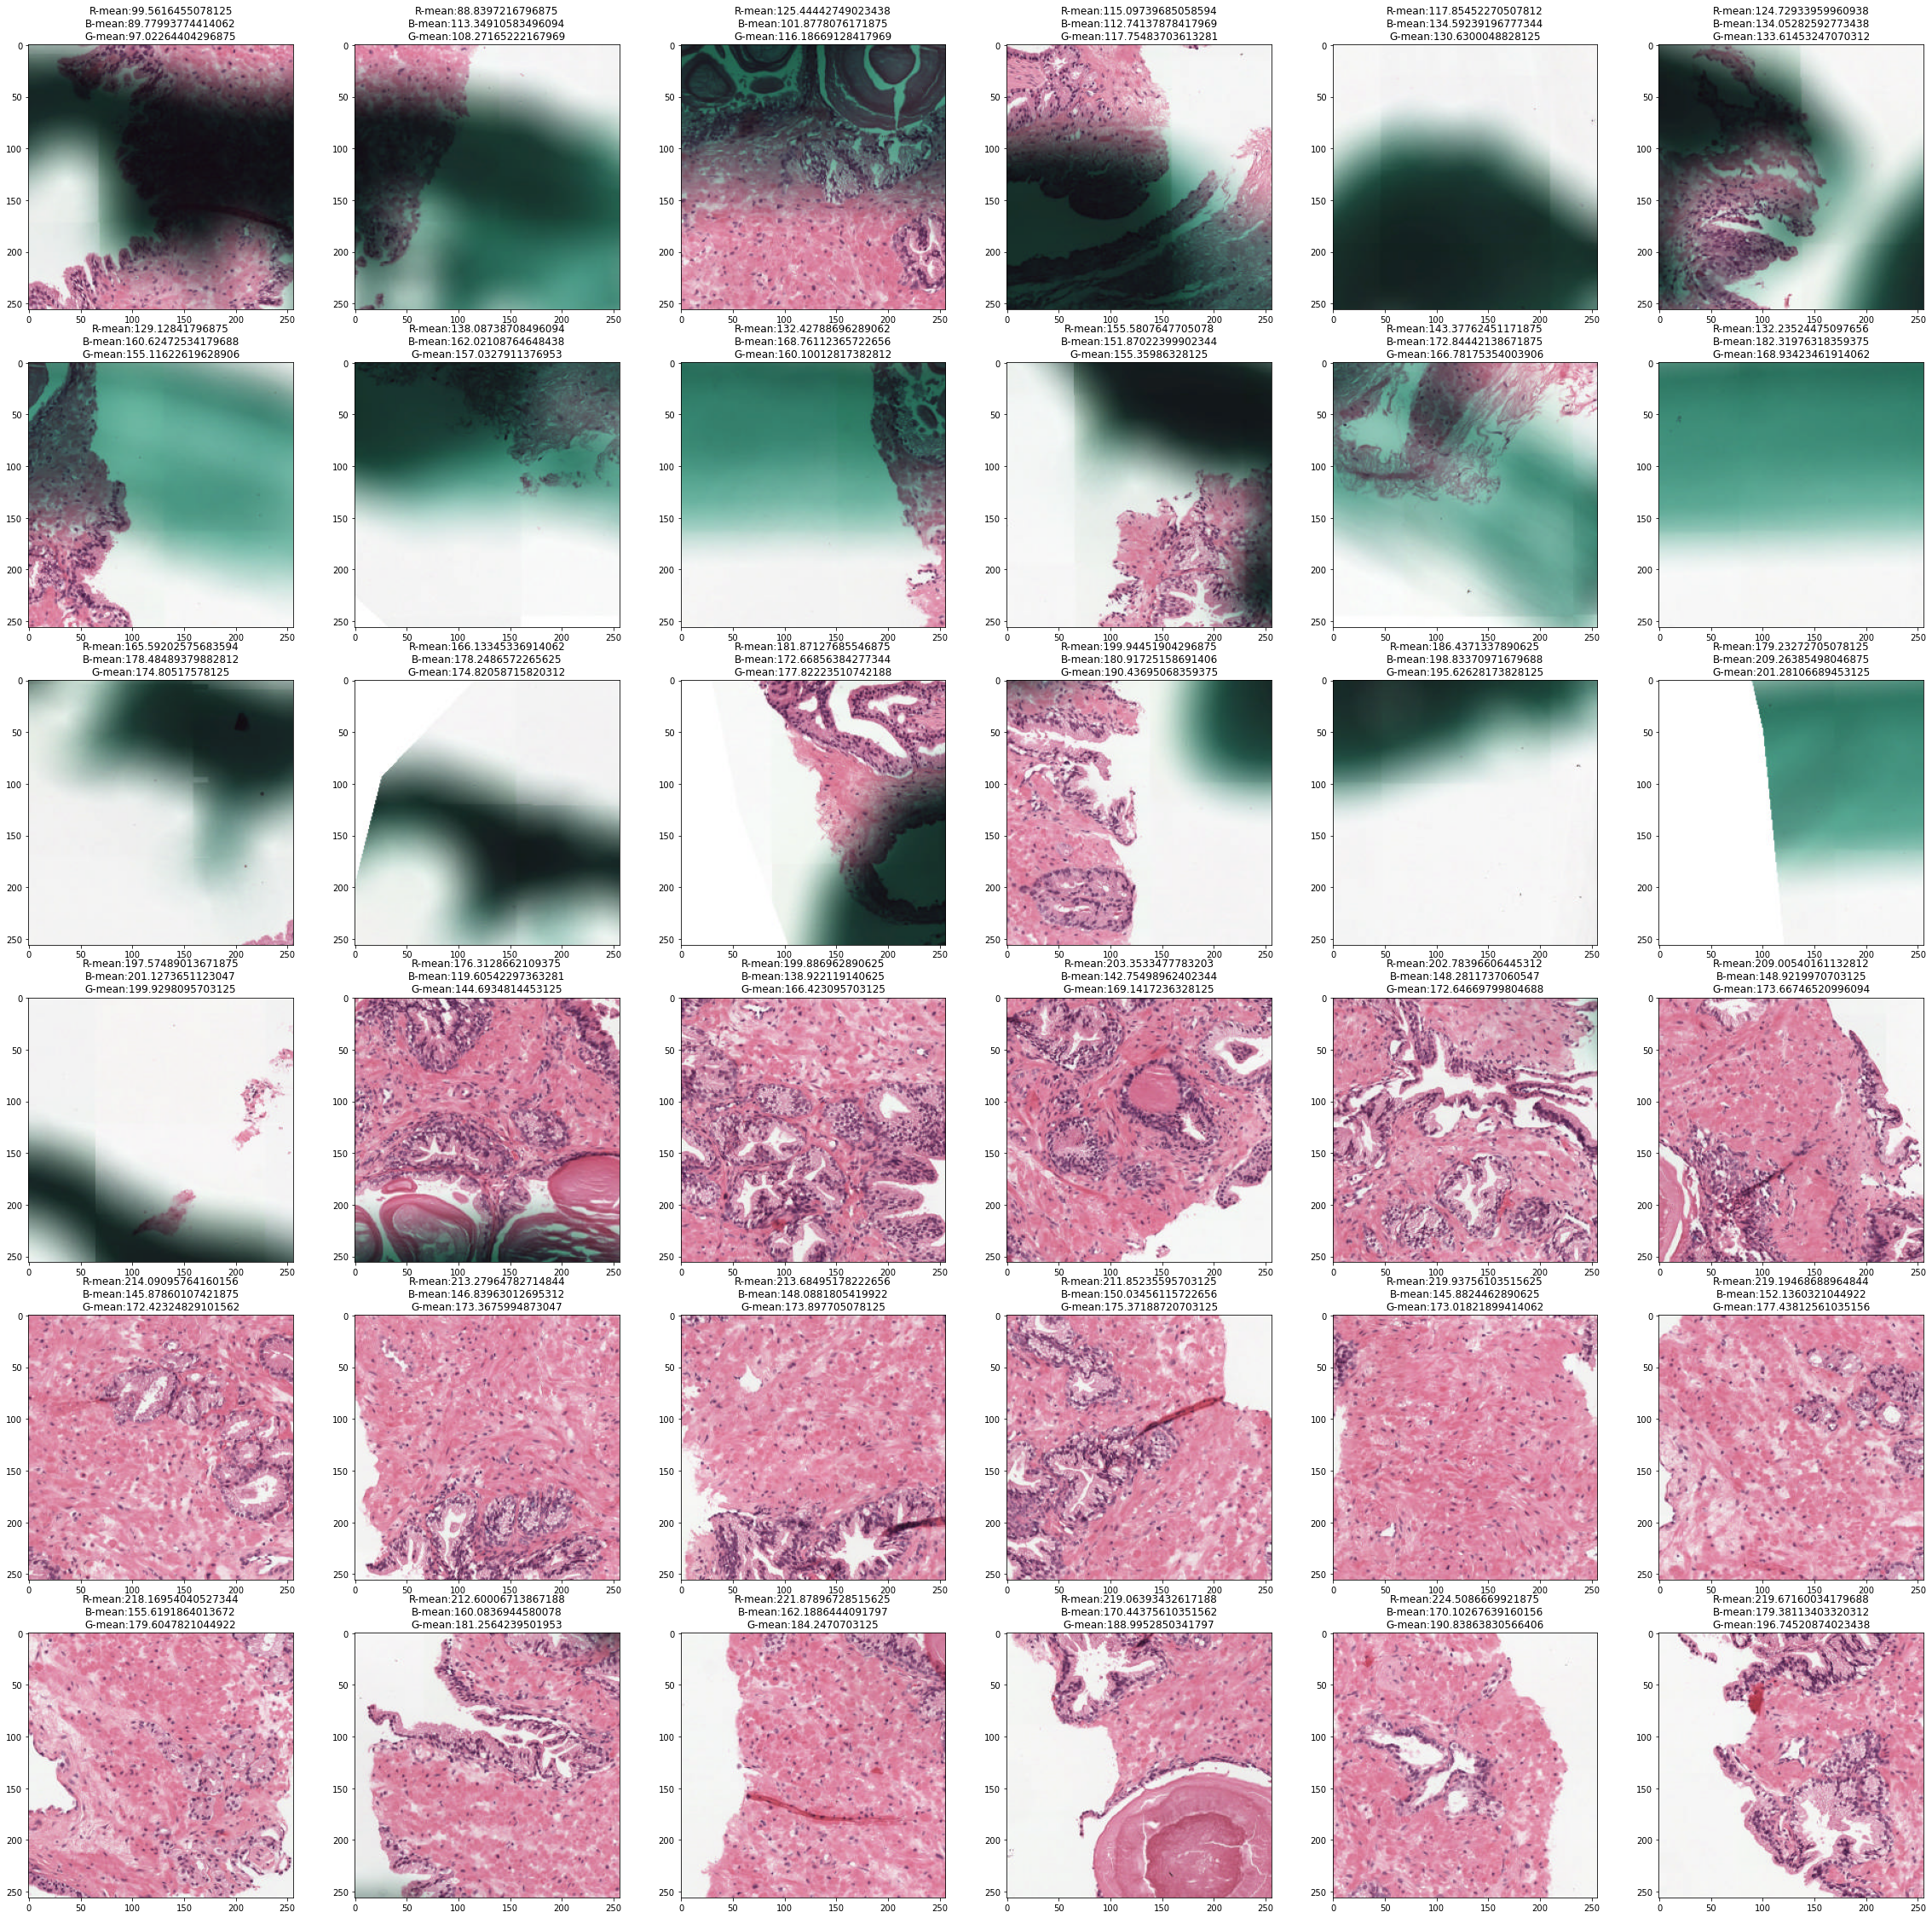

In [8]:
f, ax = plt.subplots(6,6, figsize=(40,40))
pen = [0,1,2,3,4,5,7,8,9,10,11,12,15,16,19,29,31,33,35]
no_pen = [6,13,14,17,18,20,21,22,23,24,25,26,27,28,30,32,34]
arrange_list = pen + no_pen
for i in range(6):
    for j in range(6):
        ax[i,j].imshow(temp_img[idxs[arrange_list[i*6+j]]])
        ax[i, j].set_title(f"R-mean:{chan_mean[idxs[arrange_list[i*6+j]]][0]}\nB-mean:"\
                           f"{chan_mean[idxs[arrange_list[i*6+j]]][1]}\nG-mean:{chan_mean[idxs[arrange_list[i*6+j]]][2]}")

In [9]:
print(f'Channel mean value differences: '\
      f'\nRed:  \t{(np.mean(chan_mean[idxs[no_pen]],axis=0)-np.mean(chan_mean[idxs[pen]],axis=0))[0]}'\
      f'\nBlue: \t{(np.mean(chan_mean[idxs[no_pen]],axis=0)-np.mean(chan_mean[idxs[pen]],axis=0))[1]}'\
      f'\nGreen: \t{(np.mean(chan_mean[idxs[no_pen]],axis=0)-np.mean(chan_mean[idxs[pen]],axis=0))[2]}'\
      f'\nTotal: \t{np.mean(sing_mean[idxs[no_pen]]) - np.mean(sing_mean[idxs[pen]])}')

Channel mean value differences: 
Red:  	65.45101319304192
Blue: 	-6.056730193619387
Green: 	19.182011040371634
Total: 	26.19209801326471


The greatest difference in pixel values between tiles with pen and tiles without pen is in the red channel; as one would expect based on viewing many tiles, the tissue is typically pink/red and when the tissue is blocked by black/green/blue pen the red channel values drop significantly.

In [10]:
np.mean(chan_mean[idxs[no_pen]],axis=0)

array([211.722087, 152.068485, 176.104509])

In [11]:
np.mean(chan_mean[idxs[pen]],axis=0)

array([146.271074, 158.125215, 156.922498])

In [15]:
np.set_printoptions(threshold=sys.maxsize)
chan_mean[idxs[no_pen]]

array([[176.312866, 119.605423, 144.693481],
       [199.886963, 138.922119, 166.423096],
       [203.353348, 142.75499 , 169.141724],
       [202.783966, 148.281174, 172.646698],
       [209.005402, 148.921997, 173.667465],
       [214.090958, 145.878601, 172.423248],
       [213.279648, 146.83963 , 173.367599],
       [213.684952, 148.088181, 173.897705],
       [211.852356, 150.034561, 175.371887],
       [219.937561, 145.882446, 173.018219],
       [219.194687, 152.136032, 177.438126],
       [218.16954 , 155.619186, 179.604782],
       [212.600067, 160.083694, 181.256424],
       [221.878967, 162.188644, 184.24707 ],
       [219.063934, 170.443756, 188.995285],
       [224.508667, 170.102676, 190.838638],
       [219.6716  , 179.381134, 196.745209]])

In [16]:
chan_mean[idxs[pen]]

array([[ 99.561646,  89.779938,  97.022644],
       [ 88.839722, 113.349106, 108.271652],
       [125.444427, 101.877808, 116.186691],
       [115.097397, 112.741379, 117.754837],
       [117.854523, 134.592392, 130.630005],
       [124.72934 , 134.052826, 133.614532],
       [129.128418, 160.624725, 155.116226],
       [138.087387, 162.021088, 157.032791],
       [132.427887, 168.761124, 160.100128],
       [155.580765, 151.870224, 155.359863],
       [143.377625, 172.844421, 166.781754],
       [132.235245, 182.319763, 168.934235],
       [165.592026, 178.484894, 174.805176],
       [166.133453, 178.248657, 174.820587],
       [181.871277, 172.668564, 177.822235],
       [199.944519, 180.917252, 190.436951],
       [186.437134, 198.83371 , 195.626282],
       [179.232727, 209.263855, 201.281067],
       [197.57489 , 201.127365, 199.92981 ]])

After completing the above analysis for a number of proper pen-free tiles, it appears that most proper tissues samples have red channel means at approximately 215 and minimums in the 200-205 range. Meanwhile, pen-marked tiles typically have a red channel mean of 145, with red channel maximums in the 195-200 range. In order to err on the side of allowing some lightly pen-marked tiles that still contain unobstructed tissue we will use a threshold of >180 on the red channel to filter out pen-marked tiles.

Examples of filtering in action:

Text(0.5, 1.0, 'Final Image With Pen-Mark Filtering')

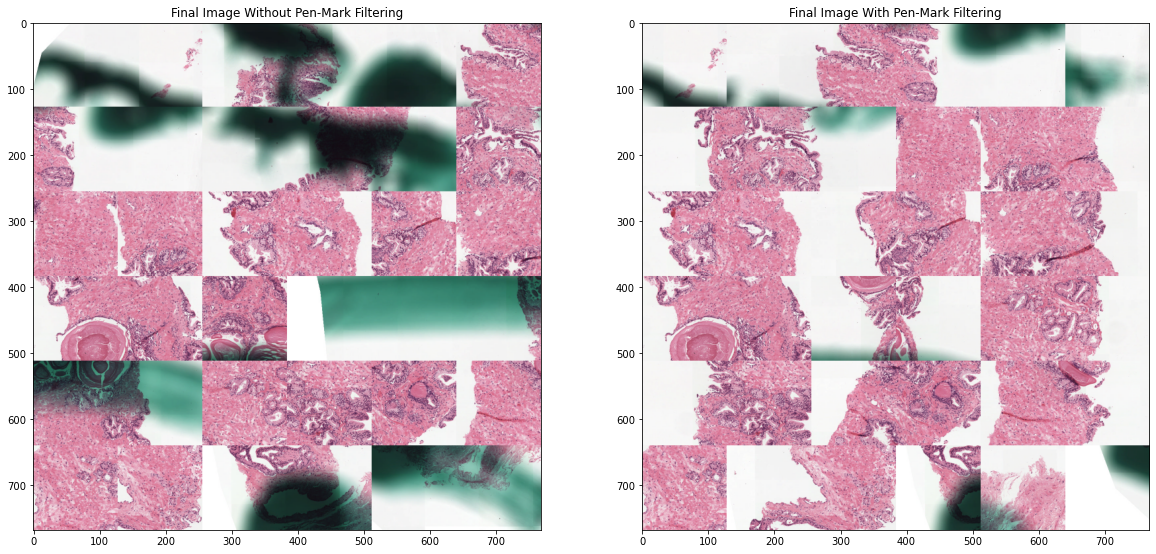

In [30]:
views=4
N=36
sz=256
lvl=1
df=train_df
img = open_slide_level(os.path.join(data_dir,'ebb6a080d72e09f6481721ef9f88c472.tiff'), lvl)
shape = img.shape
pad0,pad1 = (sz - shape[0]%sz)%sz, (sz - shape[1]%sz)%sz
base_img = np.pad(img,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2],[0,0]],
            constant_values=255)
base_shape = base_img.shape


# Create a final image without filtering:
temp_img = base_img
shape = temp_img.shape
temp_img = temp_img.reshape(shape[0]//sz,sz,shape[1]//sz,sz,3)
temp_img = temp_img.transpose(0,2,1,3,4).reshape(-1,sz,sz,3)
if len(temp_img) < 2*N:
    temp_img = np.pad(temp_img,[[0,2*N-len(temp_img)],[0,0],[0,0],[0,0]],constant_values=255) 
chan_mean = np.mean(temp_img,axis=(1,2))
sing_mean = np.mean(chan_mean, axis = 1)
idxs = np.argsort(sing_mean)
# No filtering step here
idxs = sorted(idxs[:N])        
temp_img = temp_img[idxs]
temp_list = []
for j in range(6):
    temp_row = np.concatenate((temp_img[j*6+0],temp_img[j*6+1],temp_img[j*6+2],
                               temp_img[j*6+3],temp_img[j*6+4],temp_img[j*6+5]),axis=1)
    temp_list.append(temp_row)
end_img = np.concatenate((temp_list[0],temp_list[1],temp_list[2],
                           temp_list[3],temp_list[4],temp_list[5]),axis=0)
unfiltered_im = cv2.resize(end_img,(768,768),interpolation = cv2.INTER_AREA)


# Use the same process but with a red-channel filter:
temp_img = base_img
shape = temp_img.shape
temp_img = temp_img.reshape(shape[0]//sz,sz,shape[1]//sz,sz,3)
temp_img = temp_img.transpose(0,2,1,3,4).reshape(-1,sz,sz,3)
if len(temp_img) < 2*N:
    temp_img = np.pad(temp_img,[[0,2*N-len(temp_img)],[0,0],[0,0],[0,0]],constant_values=255) 
chan_mean = np.mean(temp_img,axis=(1,2))
sing_mean = np.mean(chan_mean, axis = 1)
idxs = np.argsort(sing_mean)
# Filtering to keep tiles with a red-channel mean greater than or equal to 190
idxs = idxs[chan_mean[idxs][:,0]>=180.0]
idxs = sorted(idxs[:N])        
temp_img = temp_img[idxs]
temp_list = []
for j in range(6):
    temp_row = np.concatenate((temp_img[j*6+0],temp_img[j*6+1],temp_img[j*6+2],
                               temp_img[j*6+3],temp_img[j*6+4],temp_img[j*6+5]),axis=1)
    temp_list.append(temp_row)
end_img = np.concatenate((temp_list[0],temp_list[1],temp_list[2],
                           temp_list[3],temp_list[4],temp_list[5]),axis=0)
filtered_im = cv2.resize(end_img,(768,768),interpolation = cv2.INTER_AREA)

# Display result
f, ax = plt.subplots(1,2, figsize=(20,20))
ax[0].imshow(unfiltered_im)
ax[0].set_title("Final Image Without Pen-Mark Filtering")
ax[1].imshow(filtered_im)
ax[1].set_title("Final Image With Pen-Mark Filtering")

Text(0.5, 1.0, 'Final Image With Pen-Mark Filtering')

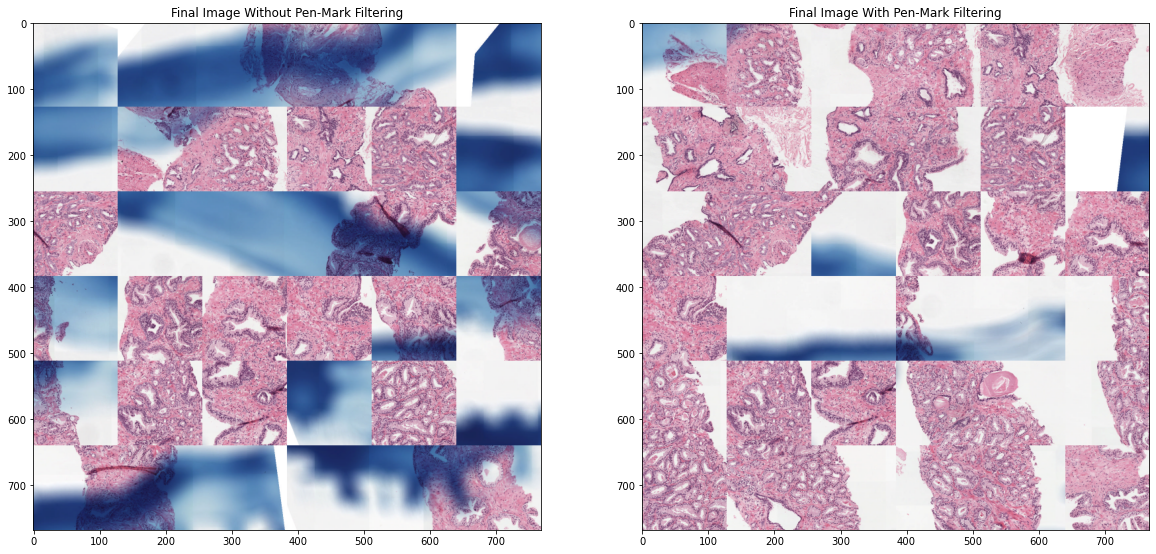

In [31]:
views=4
N=36
sz=256
lvl=1
df=train_df
img = open_slide_level(os.path.join(data_dir,'ebb6d5ca45942536f78beb451ee43cc4.tiff'), lvl)
shape = img.shape
pad0,pad1 = (sz - shape[0]%sz)%sz, (sz - shape[1]%sz)%sz
base_img = np.pad(img,[[pad0//2,pad0-pad0//2],[pad1//2,pad1-pad1//2],[0,0]],
            constant_values=255)
base_shape = base_img.shape


# Create a final image without filtering:
temp_img = base_img
shape = temp_img.shape
temp_img = temp_img.reshape(shape[0]//sz,sz,shape[1]//sz,sz,3)
temp_img = temp_img.transpose(0,2,1,3,4).reshape(-1,sz,sz,3)
if len(temp_img) < 2*N:
    temp_img = np.pad(temp_img,[[0,2*N-len(temp_img)],[0,0],[0,0],[0,0]],constant_values=255) 
chan_mean = np.mean(temp_img,axis=(1,2))
sing_mean = np.mean(chan_mean, axis = 1)
idxs = np.argsort(sing_mean)
# No filtering step here
idxs = sorted(idxs[:N])        
temp_img = temp_img[idxs]
temp_list = []
for j in range(6):
    temp_row = np.concatenate((temp_img[j*6+0],temp_img[j*6+1],temp_img[j*6+2],
                               temp_img[j*6+3],temp_img[j*6+4],temp_img[j*6+5]),axis=1)
    temp_list.append(temp_row)
end_img = np.concatenate((temp_list[0],temp_list[1],temp_list[2],
                           temp_list[3],temp_list[4],temp_list[5]),axis=0)
unfiltered_im = cv2.resize(end_img,(768,768),interpolation = cv2.INTER_AREA)


# Use the same process but with a red-channel filter:
temp_img = base_img
shape = temp_img.shape
temp_img = temp_img.reshape(shape[0]//sz,sz,shape[1]//sz,sz,3)
temp_img = temp_img.transpose(0,2,1,3,4).reshape(-1,sz,sz,3)
if len(temp_img) < 2*N:
    temp_img = np.pad(temp_img,[[0,2*N-len(temp_img)],[0,0],[0,0],[0,0]],constant_values=255) 
chan_mean = np.mean(temp_img,axis=(1,2))
sing_mean = np.mean(chan_mean, axis = 1)
idxs = np.argsort(sing_mean)
# Filtering to keep tiles with a red-channel mean greater than or equal to 190
idxs = idxs[chan_mean[idxs][:,0]>=180.0]
idxs = sorted(idxs[:N])        
temp_img = temp_img[idxs]
temp_list = []
for j in range(6):
    temp_row = np.concatenate((temp_img[j*6+0],temp_img[j*6+1],temp_img[j*6+2],
                               temp_img[j*6+3],temp_img[j*6+4],temp_img[j*6+5]),axis=1)
    temp_list.append(temp_row)
end_img = np.concatenate((temp_list[0],temp_list[1],temp_list[2],
                           temp_list[3],temp_list[4],temp_list[5]),axis=0)
filtered_im = cv2.resize(end_img,(768,768),interpolation = cv2.INTER_AREA)

# Display result
f, ax = plt.subplots(1,2, figsize=(20,20))
ax[0].imshow(unfiltered_im)
ax[0].set_title("Final Image Without Pen-Mark Filtering")
ax[1].imshow(filtered_im)
ax[1].set_title("Final Image With Pen-Mark Filtering")


The filter does not catch all pen-marked areas, particularly those that are small regions of pen mark with large portions of white accompanying because the whitespace raises the mean pixel value for all channels, but the result shows significant improvement over no filtering.